Import bibliotek

In [2]:
import os
import nltk
import json
import string
import numpy as np
import morfeusz2
import pandas as pd
import itertools as it
import operator as op
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


1. Utworzenie korpusu dokumentów

In [3]:
corpus_dir = "./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()
files

['Harry Potter i Czara Ognia.txt',
 'Harry Potter i Insygnia Smierci.txt',
 'Harry Potter i Kamien Filozoficzny.txt',
 'Harry Potter i Komnata Tajemnic.txt',
 'Harry Potter i Ksiaze Polkrwi.txt',
 'Harry Potter i Przeklete Dziecko.txt',
 'Harry Potter i Wiezien Azkabanu.txt',
 'Harry Potter i Zakon Feniksa.txt',
 'Opowiesci z Narni. Kon i jego chlopiec.txt',
 'Opowiesci z Narni. Ksiaze Kaspian.txt',
 'Opowiesci z Narni. Lew, czarownica i stara szafa.txt',
 'Opowiesci z Narni. Ostatnia bitwa.txt',
 'Opowiesci z Narni. Podroz Wedrowca do Switu.txt',
 'Opowiesci z Narni. Siostrzeniec Czarodzieja.txt',
 'Opowiesci z Narni. Srebrne krzeslo.txt',
 'Zmierzch.Ksiezyc w Nowiu.txt',
 'Zmierzch.Przed Switem.txt',
 'Zmierzch.Zacmienie.txt',
 'Zmierzch.Zmierzch.txt',
 'Zmierzch.Zycie i Smierc.txt']

2. Wstępne przygotowanie dokumentów

In [4]:
documents = {}
for f in files:
    documents[f] = corpus.raw(f)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Harry Potter i Czara Ognia.txt": "Lord Voldemort, wraz ze swoim sługą Glizdogonem przybywa do domu należącego niegdyś do rodziny Riddle'ów położonego w Little Hangleton. Tam układają plan dotyczący zamordowania Harry'ego Pottera, co ma pomóc Czarnemu Panu w odzyskaniu jego dawnej mocy. Jest także mowa o wiernym słudze Czarnego Pana, który wkrótce ma znaleźć się w Hogwarcie. Wszystko to słyszy mieszkający nieopodal ogrodnik, Frank Bryce. Voldemort odkrywając, iż mężczyzna podsłuchuje, zaprasza go do środka i uśmierca. Harry budzi się z przerażającego snu. Jego blizna pulsuje okropnym bólem. Próbuje sobie przypomnieć o czym śnił, a z pamięci wyłania się obraz mrocznego pokoju, węża leżącego przed kominkiem oraz Glizdogona i Lorda Voldemorta planujących morderstwo. Harry zastanawia się czy powinien komuś powiedzieć o problemach z blizną, ponieważ, gdy bolała go ostatnim razem, Voldemort wdarł się do Hogwartu. Ostatecznie postanawia napisać do Syriusza i zejść na śniadanie. W trakci

In [5]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [6]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma)
                for _, _, (_, lemma, descr, _, _,) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [7]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pietr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
for key in documents:
    documents[key] =documents[key].lower()
    documents[key] ="".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Harry Potter i Czara Ognia.txt": "lord voldemort wraz sługa glizdogonem przybywać dom należący niegdyś rodzina riddleów położony little hangleton układać plan dotyczyć zamordować harryego pottera mieć pomóc czarny odzyskanie dawny moc mowa wierna sługa czarny wkrótce mieć znaleźć hogwarcie słyszeć mieszkać nieopodal ogrodnik frank bryka voldemort odkrywać mężczyzna podsłuchiwać zapraszać środek uśmiercać Harry budzić przerażający sen blizna pulsować okropny ból próbować siebie przypomnieć czym śnić a pamięć wyłaniać obraza mroczny pokój wąż leżący kominek glizdogona lord voldemorta planować morderstwo Harry zastanawiać powinien ktoś powiedzieć problem blizna boleć ostatni razem voldemort wedrzeć hogwartu ostatecznie postanawiać napisać Syriusz zejść śniadanie trakt śniadanie wuj vernon otrzymywać lista weasleyowie oferować zabrać harryego finał mistrzostwa świat quidditchu ugościć reszta wakacje długi namysł użycie harryego odpowiedni argument wuj zgadzać wyjazd pokój Harry zast

3. Utworzenie macierzy częstości

In [9]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

,content
Harry Potter i Czara Ognia.txt,lord voldemort wraz sługa glizdogonem przybywa...
Harry Potter i Insygnia Smierci.txt,podczas zebranie śmierciożerca odbywać dwór ma...
Harry Potter i Kamien Filozoficzny.txt,ulica privet drive pojawiać stary człowiek dłu...
Harry Potter i Komnata Tajemnic.txt,wuj vernon zły hedwiga robić bałagan dom tymcz...
Harry Potter i Ksiaze Polkrwi.txt,mugolskiego premiera odwiedzać Korneliusz knot...
Harry Potter i Przeklete Dziecko.txt,scena pierwsza druga opowiadać historia zostać...
Harry Potter i Wiezien Azkabanu.txt,Harry leż koc łóżko odrabiać praca domowy zada...
Harry Potter i Zakon Feniksa.txt,dudley zły wyżywać Harry dudley zostawać zaata...
Opowiesci z Narni. Kon i jego chlopiec.txt,akcja książka rozgrywać narnii czas panowanie ...
Opowiesci z Narni. Ksiaze Kaspian.txt,mijać rok wydarzenie opisać powieść lewa czaro...


In [10]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 2, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(20, 4675))

In [11]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00762238,
        0.        ],
       [0.        , 0.03080164, 0.        , ..., 0.        , 0.01221555,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04321792, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(20, 4675))

4. Chmury tagów

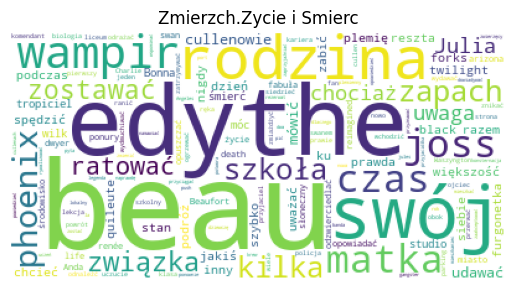

In [12]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)

if not os.path.exists("./chmury"):
    os.mkdir("./chmury")

for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))

5. Topic modelling

In [13]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")

def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")


In [14]:
def plot_documents(model, counts, files_names, n_components, title):
  colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']
  docs_topics = pd.DataFrame(model.transform(counts), columns=[f"Topic {x}" for x in range(n_components)])
  docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
  plt.figure(figsize=(7,4))
  left = [0] * len(docs_topics)
  for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
  plt.gcf().subplots_adjust(left=0.5)
  plt.savefig(f"./tematy/{title}_docs.png")
  plt.close()

In [15]:
n_components = 3
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 20
subplots = (1,3)

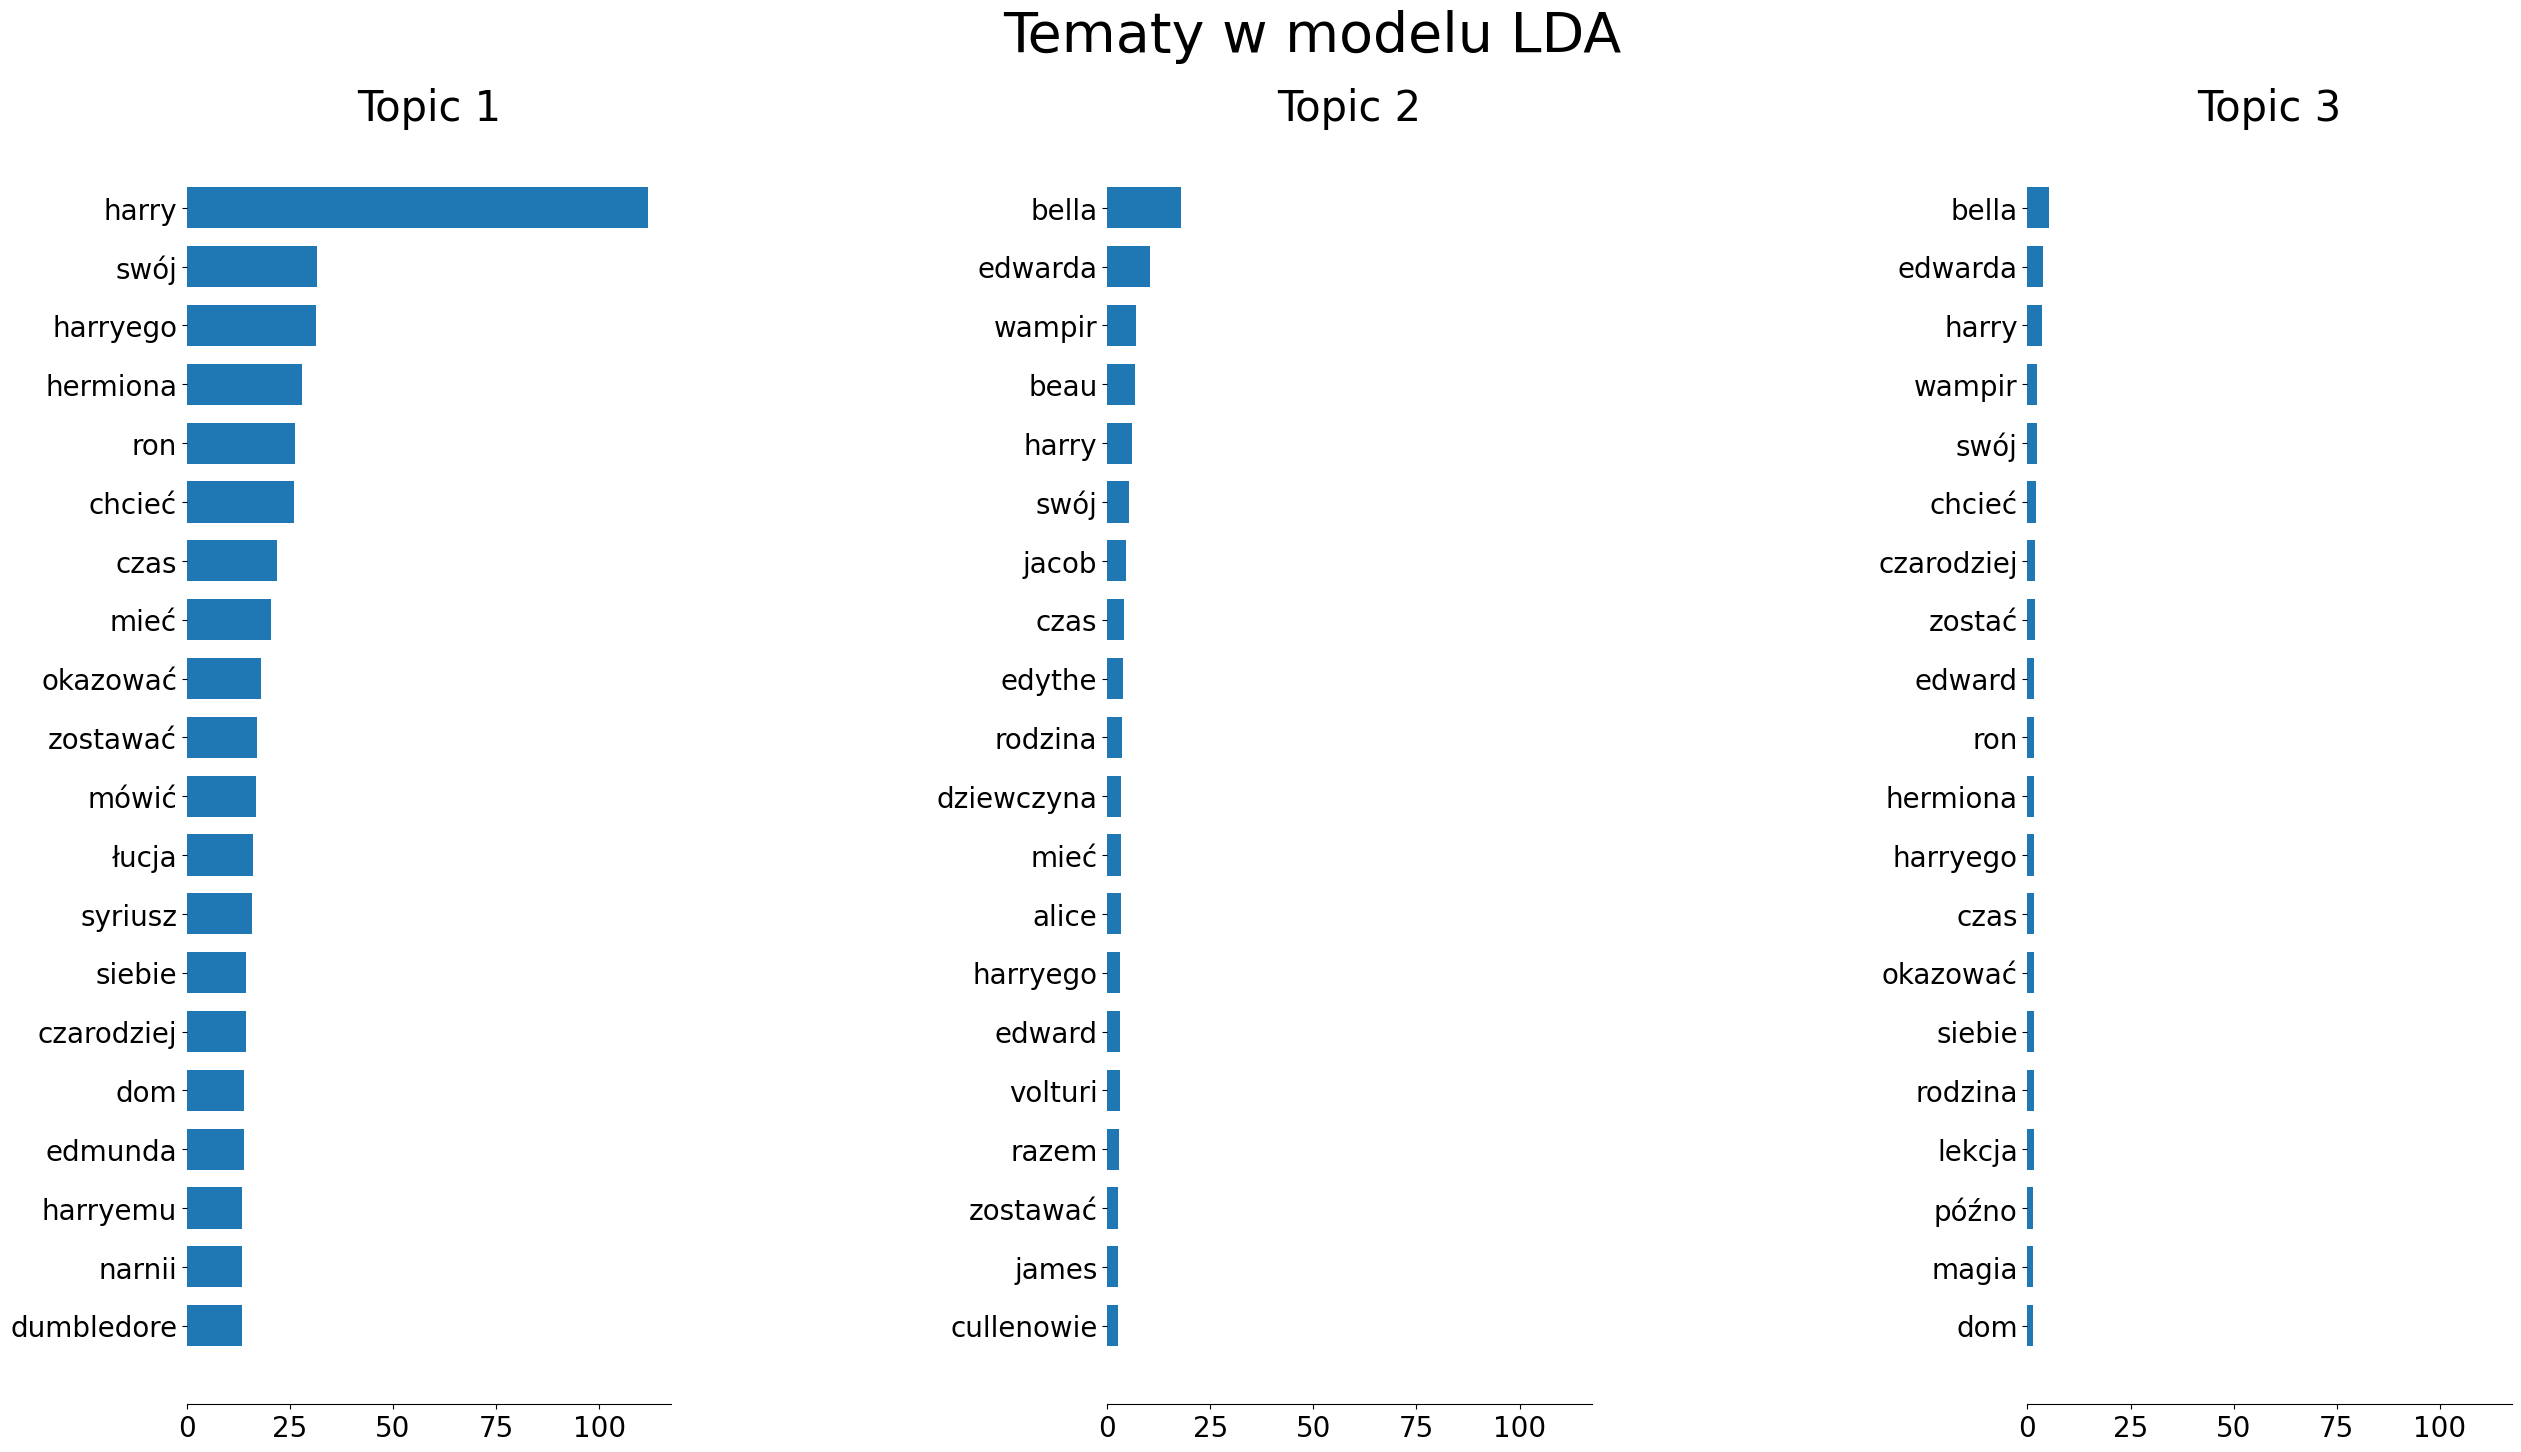

In [16]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)

lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)
plot_documents(lda, counts_tf, files, n_components, "Tematy w modelu LDA")

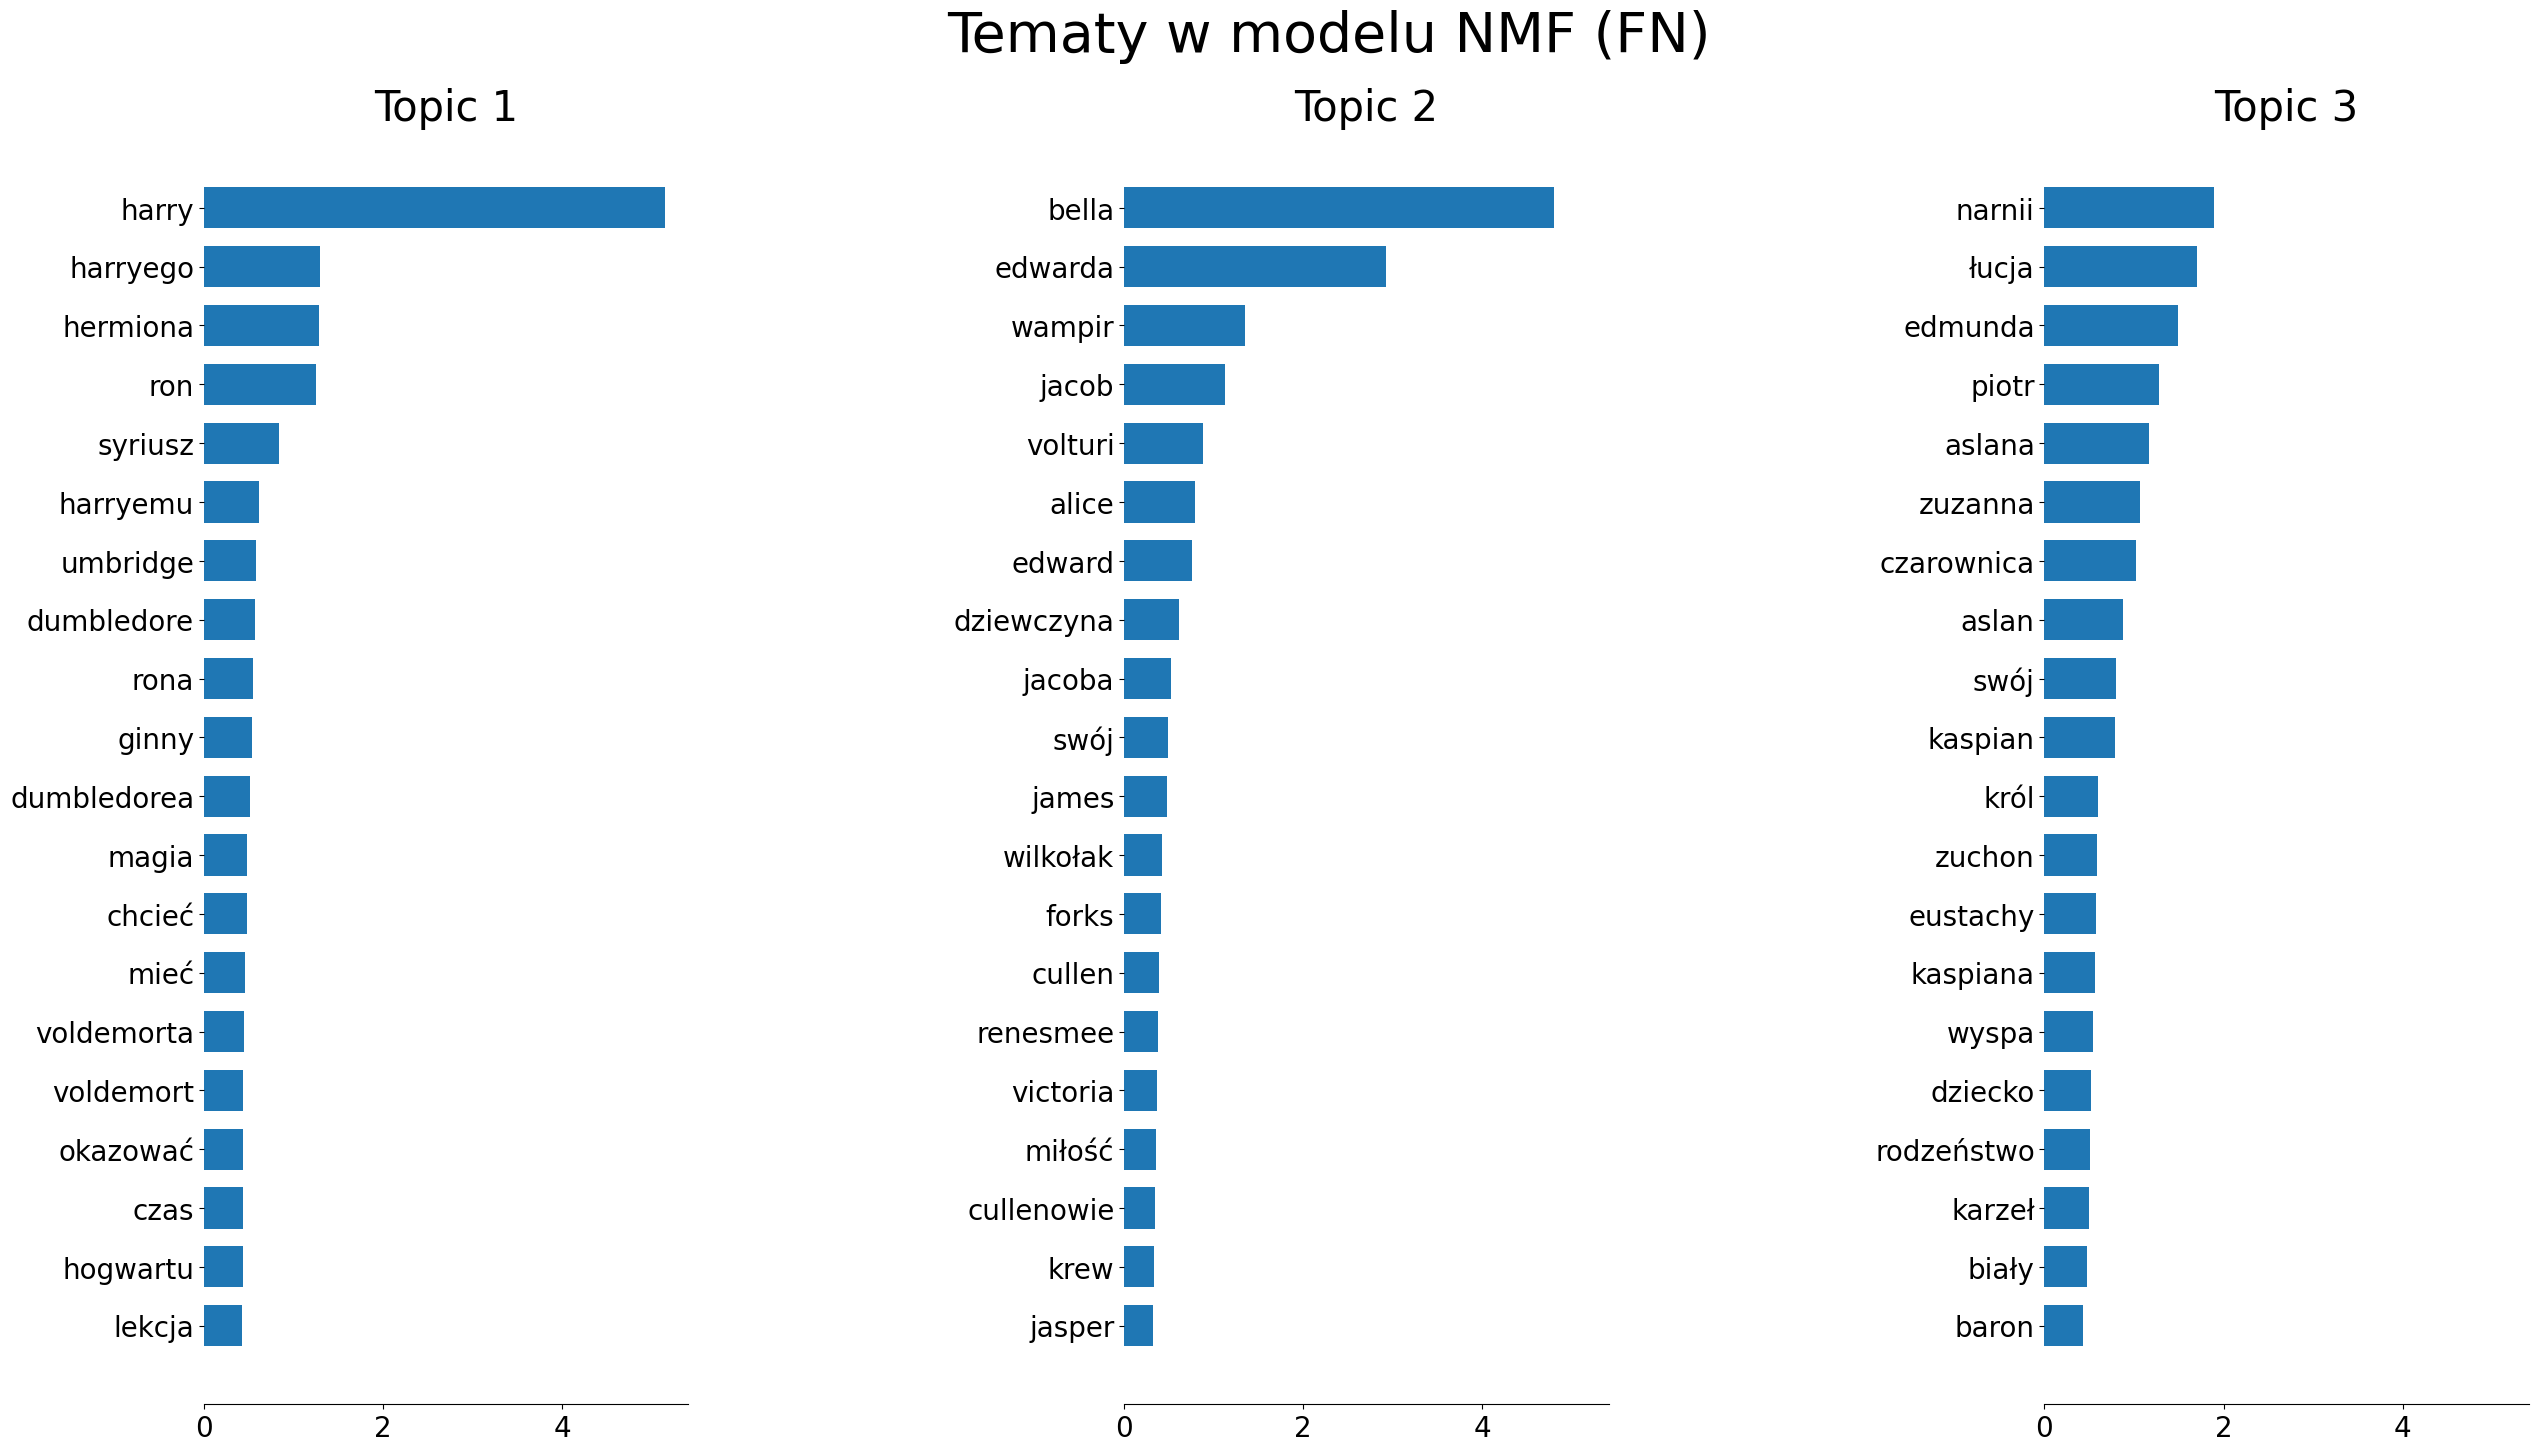

In [17]:
nmf_fn = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=0.00005,
    alpha_W=0.00005,
    l1_ratio=0.5
)

nmf_fn.fit(counts_tfidf)
plot_top_words(nmf_fn, feature_names, n_top_words, "Tematy w modelu NMF (FN)", subplots)
plot_documents(nmf_fn, counts_tfidf, files, n_components, "Tematy w modelu NMF(FN)")

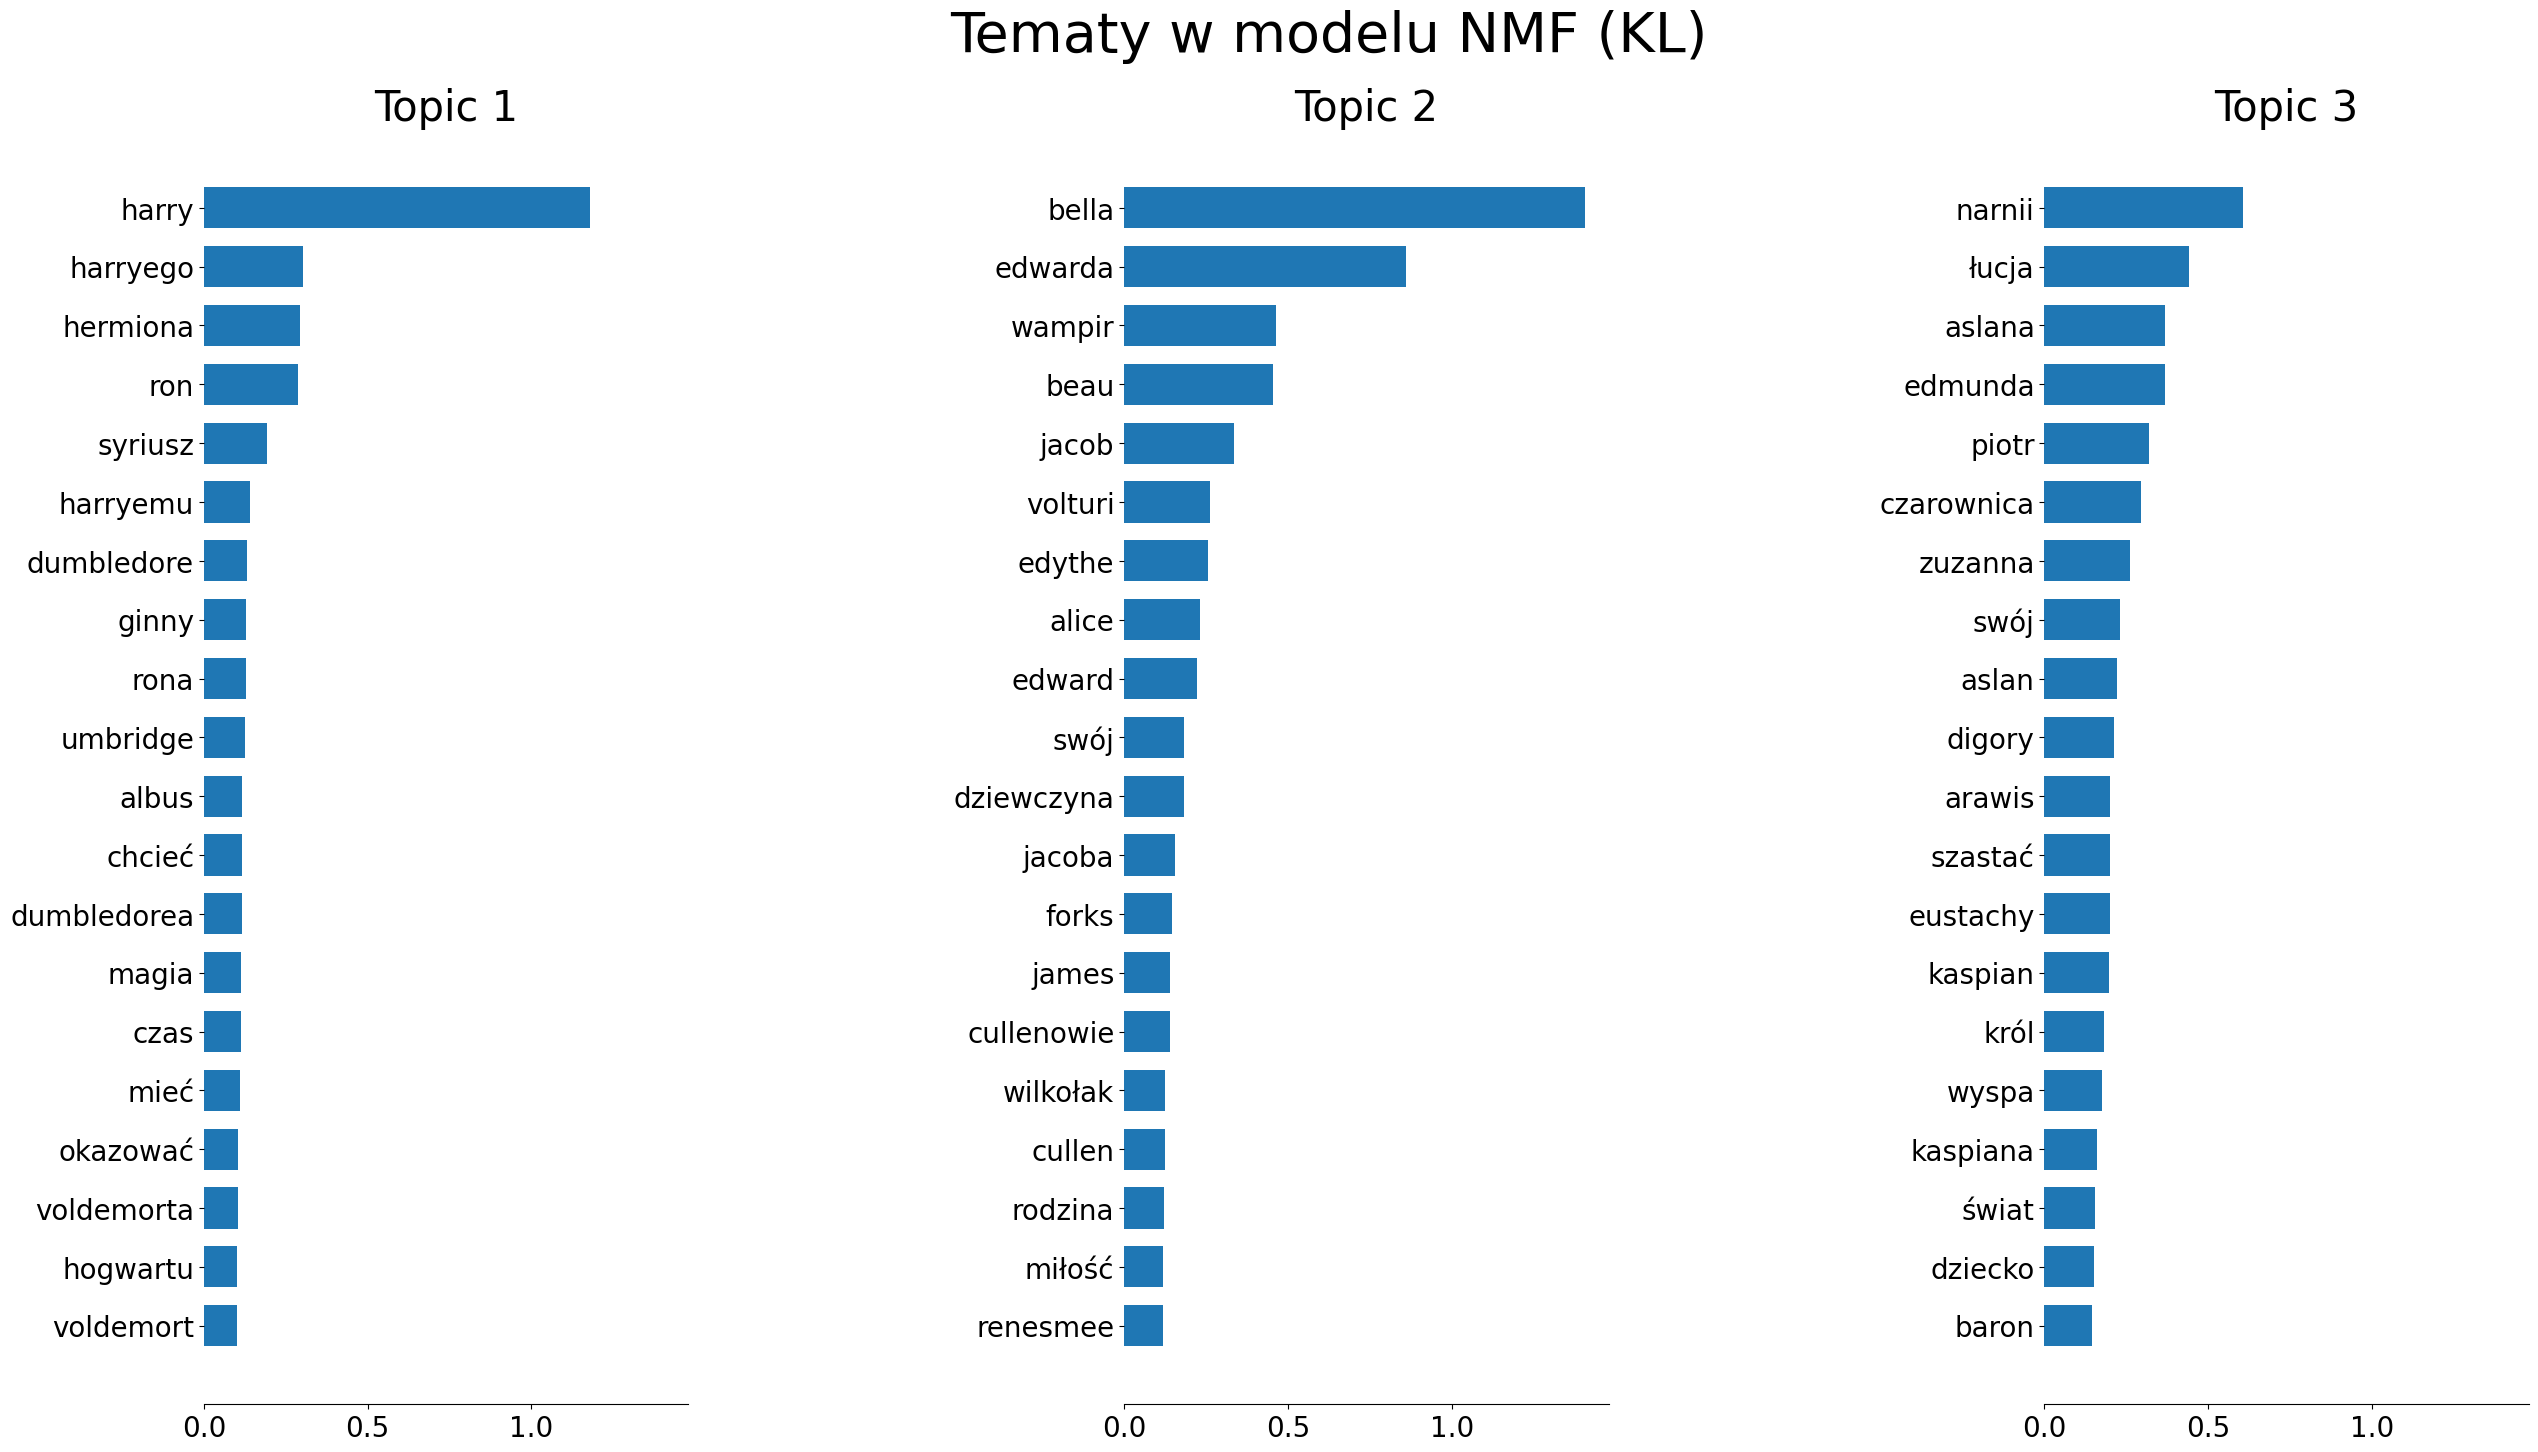

In [18]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=0.00005,
    alpha_W=0.00005,
    l1_ratio=0.5
)

nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_words, "Tematy w modelu NMF (KL)", subplots)
plot_documents(nmf_kl, counts_tf, files, n_components, "Tematy w modelu NMF(KL)")

6. Analiza skupień

In [19]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    plt.figure(figsize=(7,4))
    dendrogram(linkage_matrix, **kwargs)


In [20]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(len(files), len(files))
cs

array([[1.        , 0.56459379, 0.49996461, 0.44767262, 0.52149357,
        0.40078115, 0.50897954, 0.53655369, 0.04978333, 0.10380695,
        0.10404309, 0.07112769, 0.12963401, 0.05238638, 0.0743698 ,
        0.07523301, 0.07354802, 0.06382731, 0.04943919, 0.0468746 ],
       [0.56459379, 1.        , 0.52301458, 0.49743212, 0.61369303,
        0.39672906, 0.47693502, 0.63244733, 0.04452801, 0.07904904,
        0.08926707, 0.07568825, 0.07242286, 0.02615922, 0.04975714,
        0.05577804, 0.0517892 , 0.04293069, 0.03814857, 0.03725055],
       [0.49996461, 0.52301458, 1.        , 0.47679174, 0.48641542,
        0.36808347, 0.43473603, 0.49712448, 0.05076594, 0.09897991,
        0.10091305, 0.04079342, 0.10974422, 0.03241139, 0.05802386,
        0.05857255, 0.05648956, 0.04425854, 0.0489129 , 0.04335849],
       [0.44767262, 0.49743212, 0.47679174, 1.        , 0.52977708,
        0.32367346, 0.388489  , 0.49314055, 0.02776739, 0.06415942,
        0.06340507, 0.04338913, 0.06073124, 0

In [21]:
if not os.path.exists("./skupienia"):
    os.mkdir("./skupienia")

In [22]:
n_clusters = 3

In [23]:
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward',
    compute_distances=True
).fit(cs)
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0])

In [24]:
plot_dendrogram(
    clustering,
    labels = files,
    orientation = 'right'
)
plt.gcf().subplots_adjust(left=0.65)
plt.savefig(f"./skupienia/cosine_ward.png")
plt.close()

In [25]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(len(files), len(files))
ed

array([[  0.        , 121.26829759, 134.65511502, 142.94054708,
        131.79908953, 140.43859868, 133.9888055 , 130.73255142,
        168.9348987 , 171.85749911, 176.79083687, 168.44583699,
        165.45694304, 169.05916124, 168.19334113, 170.038231  ,
        169.55824958, 168.61198059, 170.35551062, 169.30741271],
       [121.26829759,   0.        ,  81.65782265,  84.05950273,
         73.53230583, 103.72559954,  85.15280383,  72.38093672,
        108.14342329, 122.18428704, 129.2091328 , 107.60111524,
        109.85444916, 108.73361946, 108.15266987, 114.59930192,
        113.21660656, 110.07270325, 111.69153952, 111.41364369],
       [134.65511502,  81.65782265,   0.        ,  59.09314681,
         65.99242381,  94.20721841,  65.09224224,  69.70652767,
         73.31439149,  94.6625586 , 104.89518578,  73.52550578,
         75.8419409 ,  74.00675645,  73.61385739,  84.05355436,
         81.63332653,  76.8635154 ,  78.35177088,  78.74642849],
       [142.94054708,  84.05950273,  

In [26]:
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='complete',
    compute_distances=True
).fit(ed)
clustering.labels_

array([1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [27]:
plot_dendrogram(
    clustering,
    labels = files,
    orientation = 'right'
)
plt.gcf().subplots_adjust(left=0.65)
plt.savefig(f"./skupienia/euclidean_complete.png")
plt.close()

7. N-gramy

In [28]:
if not os.path.exists("./ngramy"):
    os.mkdir("./ngramy")

In [33]:
n = 3
if not os.path.exists(f'./ngramy/{n}'):
    os.mkdir(f'./ngramy/{n}')

In [34]:
documents_tokenized = {}
for filename in documents:
    documents_tokenized[filename] = word_tokenize(documents[filename], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{
    "Harry Potter i Czara Ognia.txt": [
        "lord",
        "voldemort",
        "wraz",
        "sługa",
        "glizdogonem",
        "przybywać",
        "dom",
        "należący",
        "niegdyś",
        "rodzina",
        "riddleów",
        "położony",
        "little",
        "hangleton",
        "układać",
        "plan",
        "dotyczyć",
        "zamordować",
        "harryego",
        "pottera",
        "mieć",
        "pomóc",
        "czarny",
        "odzyskanie",
        "dawny",
        "moc",
        "mowa",
        "wierna",
        "sługa",
        "czarny",
        "wkrótce",
        "mieć",
        "znaleźć",
        "hogwarcie",
        "słyszeć",
        "mieszkać",
        "nieopodal",
        "ogrodnik",
        "frank",
        "bryka",
        "voldemort",
        "odkrywać",
        "mężczyzna",
        "podsłuchiwać",
        "zapraszać",
        "środek",
        "uśmiercać",
        "Harry",
        "budzić",
        "przerażający",
        

In [35]:
for filename in documents_tokenized:
    n_grams = pd.Series(ngrams(documents_tokenized[filename], n)).value_counts()
    n_grams[:5].plot.barh()
    plt.gcf().subplots_adjust(left=0.45)
    plt.savefig(f"./ngramy/{n}/{filename.replace('.txt', '.png')}")
    plt.close()

In [36]:
texts = ' '.join(docs['content']).split(" ")
n_grams = pd.Series(ngrams(texts, n)).value_counts()
n_grams[:15].plot.barh()
plt.gcf().subplots_adjust(left=0.45)
plt.savefig(f"./ngramy/{n}/all.png")
plt.close()